In [1]:
import os
import sys
import random 

import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt 

sys.path.append("..")

from IPython import display

%load_ext autoreload
%autoreload 2

In [2]:
import albumentations as albu

## Download datasets

In [3]:
# mnist = torchvision.datasets.MNIST("../datasets", train=True, download=True)
# cifar10 = torchvision.datasets.CIFAR10("../datasets", download=True)
# cifar100 = torchvision.datasets.CIFAR100("../datasets", download=True)

In [4]:
# !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

## Test

In [5]:
# !pip install torchvision

In [6]:
from src.augmentations import get_aug
from src.datasets import MNIST, CIFAR10, CIFAR100
# from src.datasets import get_dataloader

In [7]:
transform = get_aug(aug_type="light", size=32)
target_transform = get_aug(aug_type="val", size=32)
# target_transform = None

In [8]:
transform, target_transform

(Compose([
   NoOp(always_apply=False, p=0.5),
   OneOf([
     GaussNoise(always_apply=False, p=0.5, var_limit=(10.0, 50.0)),
     GlassBlur(always_apply=False, p=0.5, sigma=0.7, max_delta=4, iterations=2),
     ISONoise(always_apply=False, p=0.5, intensity=(0.1, 0.5), color_shift=(0.01, 0.05)),
     MultiplicativeNoise(always_apply=False, p=0.5, multiplier=(0.9, 1.1), per_channel=False, elementwise=False),
   ], p=1.0),
   Compose([
     Normalize(always_apply=False, p=1.0, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
     ToTensorV2(always_apply=True, p=1.0),
   ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
 Compose([
   Compose([
     Normalize(always_apply=False, p=1.0, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
     ToTensorV2(always_apply=True, p=1.0),
   ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
 ], p

In [9]:
trainset = CIFAR10(root='../datasets', train=True, transform=transform, target_transform=target_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

# valset = CIFAR10(root='../datasets', train=False, transform=transform, target_transform=target_transform)
# valloader = torch.utils.data.DataLoader(valset, batch_size=16,
#                                          shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [10]:
image, target = trainset[0]
print(image.shape, target.shape)
print(image.max(), image.min())

torch.Size([3, 32, 32]) torch.Size([3, 32, 32])
tensor(0.7333) tensor(-0.9137)


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
input, target = dataiter.next()

In [12]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [50]:
model = torchvision.models.resnet18(pretrained=True)

model.fc = Identity()
model.to("cpu")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [51]:
mock = torch.rand((3, 3, 32, 32))

In [52]:
result = model(mock)

In [62]:
all_input_features = [result.detach() for _ in range(4)]
print(len(all_input_features))

4


In [66]:
input_features = torch.cat(all_input_features, dim=0)
input_features.shape

torch.Size([12, 512])

In [18]:
input.shape, target.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64, 3, 32, 32]))

In [42]:
class HDRLoss(nn.Module):
    """High dynamic range loss."""

    def __init__(self, eps=0.01):
        """Initializes loss with numerical stability epsilon."""

        super(HDRLoss, self).__init__()
        self._eps = eps


    def forward(self, denoised, target):
        """Computes loss by unpacking render buffer."""

        loss = ((denoised - target) ** 2) / (denoised + self._eps) ** 2
        return loss.mean(dim=[1,2,3])

In [43]:
hdr = HDRLoss()

In [48]:
loss = hdr(target+ 0.001, target)
print(loss.shape)

torch.Size([64])


In [49]:
loss

tensor([0.0018, 0.0063, 0.0132, 0.0148, 0.0052, 0.0149, 0.0131, 0.0051, 0.0057,
        0.0120, 0.0034, 0.0139, 0.0053, 0.0045, 0.0126, 0.0103, 0.0034, 0.0086,
        0.0137, 0.0029, 0.0041, 0.0092, 0.0211, 0.0035, 0.0098, 0.0171, 0.0099,
        0.0213, 0.0034, 0.0148, 0.0012, 0.0086, 0.0064, 0.0122, 0.0109, 0.0090,
        0.0041, 0.0075, 0.0034, 0.0133, 0.0080, 0.0070, 0.0143, 0.0216, 0.0166,
        0.0074, 0.0052, 0.0058, 0.0109, 0.0109, 0.0075, 0.0097, 0.0109, 0.0029,
        0.0149, 0.0081, 0.0040, 0.0074, 0.0048, 0.0187, 0.0125, 0.0052, 0.0142,
        0.0051])

torch.Size([64, 3, 32, 32])
torch.Size([3, 70, 274])


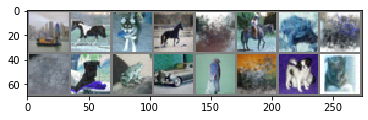

In [29]:
# show images
print(images.shape)
grid = torchvision.utils.make_grid(images[:16])
print(grid.shape)
imshow(grid)

In [ ]:
imshow(torchvision.utils.make_grid(target))

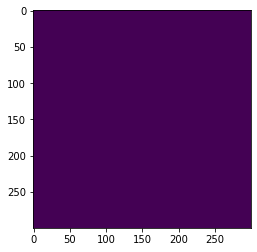

In [33]:

# plt.imshow(image[:, :, 0])

In [31]:
import photosynthesis_metrics as pm